# Problem Statement

"To build a predictive model to predict the likelihood of a customer churning"



### Dataset Description

The data provides historical customer transactions for a retailer, for purchases made on their
e-commerce platform between Dec 2010 to Dec 2011.  
Customers are uniquely identified by their Customer ID. 


### Churn Definition (Target Variable definition)

·        Customers who have made a transaction between 1st Dec 2010 to 31st Aug 2011 are labelled as “Not Churn”.

·        Customers who have NOT made any subsequent purchase in the period Sep 2011 to Dec 2011 are labeled as “Churn”.

# Solution:

•	Target variable creation (Churn/ Not Churn)

•	Customer level feature creation, from transaction dataset

•	Exploratory Data Analysis(EDA) on the features created

•	Model training, validation and evaluation


### 1. First we Import required libraries!

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

### 2. Read the data and create dataframe!

In [9]:
data = pd.read_excel("Online Retail.xlsx")

In [40]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 3. For better analysis, we filter data by dropping the duplicates(if any)!

In [41]:
filtered_data=data[['Country','CustomerID']].drop_duplicates()

### 4. Just checking first 5 countries with max customers!

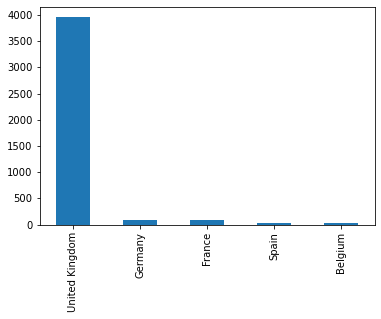

In [42]:
filtered_data.Country.value_counts()[:5].plot(kind='bar')
plt.show()

### 5. We got a insight that max Customers are from UK, so we filter the data for UK!

In [34]:
uk_data=data[data.Country=='United Kingdom']
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495478 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    495478 non-null  object        
 1   StockCode    495478 non-null  object        
 2   Description  494024 non-null  object        
 3   Quantity     495478 non-null  int64         
 4   InvoiceDate  495478 non-null  datetime64[ns]
 5   UnitPrice    495478 non-null  float64       
 6   CustomerID   361878 non-null  float64       
 7   Country      495478 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 34.0+ MB


#### Performing Descriptive Statistics for UK!

In [44]:
uk_data.describe()

,Quantity,UnitPrice,CustomerID
count,486286.000000,486286.000000,354345.000000
mean,9.734640,3.794976,15552.436219
std,163.262428,41.271159,1594.546025
min,1.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15522.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,13541.330000,18287.000000


### 6. Next, since Negative Quantity is not possible, we shall consider only Positive Quantity!

In [45]:
uk_data = uk_data[(uk_data['Quantity']>0)]
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486286 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    486286 non-null  object        
 1   StockCode    486286 non-null  object        
 2   Description  485694 non-null  object        
 3   Quantity     486286 non-null  int64         
 4   InvoiceDate  486286 non-null  datetime64[ns]
 5   UnitPrice    486286 non-null  float64       
 6   CustomerID   354345 non-null  float64       
 7   Country      486286 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.4+ MB


### 7. Customer Level Feature creation!
For further calculations we only require CustomerID, InvoiceDate, InvoiceNo, Quantity and UnitPrice

Total Purchase = Quantity * UnitPrice

In [47]:
uk_data=uk_data[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]

#Calulate total purchase
uk_data['TotalPurchase'] = uk_data['Quantity'] * uk_data['UnitPrice']

### Calcualtions:

Number of days between the present date and the date of last purchase from each customer

Number of orders for each customer

Sum of purchase price for each customer


In [48]:
uk_data_group=uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (date.max() - date.min()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'Quantity': lambda quant: quant.sum(),
                                        'TotalPurchase': lambda price: price.sum()})

uk_data_group.head()

,InvoiceDate,InvoiceNo,Quantity,TotalPurchase
CustomerID,,,,
12346.0,0,1,74215,77183.60
12747.0,366,103,1275,4196.01
12748.0,372,4596,25748,33719.73
12749.0,209,199,1471,4090.88
12820.0,323,59,722,942.34


### 8. Change the name of columns!

In [49]:

uk_data_group.columns=['num_days','num_transactions','num_units','spent_money']
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money
CustomerID,,,,
12346.0,0,1,74215,77183.60
12747.0,366,103,1275,4196.01
12748.0,372,4596,25748,33719.73
12749.0,209,199,1471,4090.88
12820.0,323,59,722,942.34


### 9. Calculating some important Values like Repeat Rate and Churn Rate

CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.

Customer Value = Average Order Value * Purchase Frequency

In [67]:
# Average Order Value
uk_data_group['avg_order_value']=uk_data_group['spent_money']/uk_data_group['num_transactions']
#uk_data_group.head()

# Purchase Frequency
purchase_frequency=sum(uk_data_group['num_transactions'])/uk_data_group.shape[0]

# Repeat Rate
repeat_rate=uk_data_group[uk_data_group.num_transactions > 1].shape[0]/uk_data_group.shape[0]

#Churn Rate
churn_rate=1-repeat_rate
purchase_frequency,repeat_rate,churn_rate

# Profit Margin
uk_data_group['profit_margin']=uk_data_group['spent_money']*0.05
#uk_data_group.head()

# Customer Value
uk_data_group['CLV']=(uk_data_group['avg_order_value']*purchase_frequency)/churn_rate

#Customer Lifetime Value
uk_data_group['cust_lifetime_value']=uk_data_group['CLV']*uk_data_group['profit_margin']
#uk_data_group.head()


### 10. Model Prediction for CLTV using Linear Regression

In [71]:
#uk_data.head()

uk_data['month_yr'] = uk_data['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y'))
uk_data.head()

# multidimensional summarization of the data
sale=uk_data.pivot_table(index=['CustomerID'],columns=['month_yr'],values='TotalPurchase',aggfunc='sum',fill_value=0).reset_index()
sale.head()

month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011
0,12346.0,0.00,0.00,0.00,0.00,0.00,77183.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,12747.0,0.00,301.70,706.27,438.50,0.00,303.04,0.00,376.30,310.78,771.31,312.73,675.38,0.00
2,12748.0,1100.37,898.24,4228.13,1070.27,389.64,418.77,1113.27,2006.26,1179.37,2234.50,10639.23,2292.84,6148.84
3,12749.0,0.00,1896.13,0.00,763.06,0.00,0.00,0.00,0.00,0.00,859.10,572.59,0.00,0.00
4,12820.0,0.00,0.00,0.00,210.35,0.00,170.46,0.00,0.00,0.00,0.00,0.00,343.76,217.77


In [72]:
#Summing all the months sales
sale['CLV']=sale.iloc[:,2:].sum(axis=1)
sale.head()

month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011,CLV
0,12346.0,0.00,0.00,0.00,0.00,0.00,77183.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,77183.60
1,12747.0,0.00,301.70,706.27,438.50,0.00,303.04,0.00,376.30,310.78,771.31,312.73,675.38,0.00,4196.01
2,12748.0,1100.37,898.24,4228.13,1070.27,389.64,418.77,1113.27,2006.26,1179.37,2234.50,10639.23,2292.84,6148.84,32619.36
3,12749.0,0.00,1896.13,0.00,763.06,0.00,0.00,0.00,0.00,0.00,859.10,572.59,0.00,0.00,4090.88
4,12820.0,0.00,0.00,0.00,210.35,0.00,170.46,0.00,0.00,0.00,0.00,0.00,343.76,217.77,942.34


In [87]:
#Selecting Feature
X=sale[['Dec-2011','Nov-2011', 'Oct-2011','Sep-2011','Aug-2011','Jul-2011']]
y=sale[['CLV']]
print(X)
print(y)

month_yr  Dec-2011  Nov-2011  Oct-2011  Sep-2011  Aug-2011  Jul-2011
0             0.00      0.00      0.00      0.00      0.00      0.00
1           438.50    312.73    675.38      0.00    301.70      0.00
2          1070.27  10639.23   2292.84   6148.84    898.24   1113.27
3           763.06    572.59      0.00      0.00   1896.13      0.00
4           210.35      0.00    343.76    217.77      0.00      0.00
...            ...       ...       ...       ...       ...       ...
3916          0.00      0.00      0.00      0.00      0.00      0.00
3917          0.00      0.00      0.00      0.00      0.00      0.00
3918         77.84      0.00      0.00      0.00    100.21      0.00
3919        208.00    651.56    114.65    134.90      0.00    143.19
3920          0.00      0.00   1072.00      0.00      0.00      0.00

[3921 rows x 6 columns]
month_yr       CLV
0         77183.60
1          4196.01
2         32619.36
3          4090.88
4           942.34
...            ...
3916        18

### 11. Dataset is divided into a training set and a test set

In [76]:
#split training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

#### Apply Linear Regression

In [106]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

[208.50969617]
[[0.99880551 0.80381254 1.60226829 1.67433228 1.52860813 2.87959449]]


### 12. Evaluating Overall Fit of the Model

In [105]:
from sklearn import metrics

# compute the R Square for model
print("R-Square:",metrics.r2_score(y_test, y_pred))

R-Square: 0.9666074402817513


In [104]:
# Evaluation Metrics used in Model Evaluation for regression problems are:

# Mean Absolute Error(MAE) using scikit-learn
print("MAE:",metrics.mean_absolute_error(y_test,y_pred))

#Mean Squared Error(MSE)
print("MSE",metrics.mean_squared_error(y_test, y_pred))

# Root Mean Squared Error(RMSE) of our predictions
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 595.0282284701236
MSE 2114139.8898678916
RMSE: 1454.008215199588
